In [1]:
import sys
sys.path.insert(1, '/t0-analysis/CKA-similarity')

import numpy as np
from CKA import CKA

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

In [2]:
# params
log_dir = "/logfiles"
model = "bigscience-T0_3B"
module = "encoder"
task = "rte"

In [3]:
# assertions
assert model == "bigscience-T0_3B"
assert module == "encoder"
assert task == "rte"

## Prompts

In [4]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}/all.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_prompt.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_target_yes_no.csv")
display(df)

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
1,mnli_crowdsource_with_targets,"{premise} Using only the above description and what you know about the world, is ""{hypothesis}"" definitely correct? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
2,based_on_previous_passage_with_targets,"{premise} Based on the previous passage, is it true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
3,infer_with_targets,"Suppose {premise} Can we infer that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
4,follow_with_targets,Given that {premise} Does it follow that {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
5,imply_with_targets,"{premise} Question: Does this imply that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
6,guaranteed_with_targets,"Given {premise} Is it guaranteed true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
7,justified_with_targets,"{premise} Are we justified in saying that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
8,must_be_true_with_targets,"Given that {premise} Therefore, it must be true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
9,should_assume_with_targets,"Given {premise} Should we assume that ""{hypothesis}"" is true? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False


## Comput CKA

In [5]:
use_pattern = [
    "gpt_3_yes_no_with_targets",
    "mnli_crowdsource_with_targets",
    "based_on_previous_passage_with_targets",
    "infer_with_targets",
    "follow_with_targets",
    "imply_with_targets",
    "guaranteed_with_targets",
    "justified_with_targets",
    "must_be_true_with_targets",
    "should_assume_with_targets",
    "gpt_3_true_false_with_targets",
    "gpt_3_cat_dog_with_targets",
    "gpt_3_cat_dog_with_targets_yes_no",
    "gpt_3_yes_no_without_targets",
    "words_appear_with_targets",
    "similar_words_with_targets",
    "start_with_the_with_targets",
    "same_meaning_with_targets",
    "paraphrase_with_targets",
    "paraphrase_r_with_targets",
    "summarize_with_targets",
    "inflection_with_targets",
    "null_pattern_with_targets",
    "null_pattern_r_with_targets",
    "null_pattern_without_targets",
    "null_pattern_r_without_targets",
    "premise_only_with_targets",
    "premise_only_without_targets",
    "hypothesis_only_with_targets",
    "hypothesis_only_without_targets",
]

In [7]:
representations = {}

for layer in tqdm(range(0, 25), desc='layers'):
    
    file_names, prompt_names = [], []

    layer_key = f"{module}-{layer}"
    if layer_key not in representations:
        representations[layer_key] = {}
    
    for _, row in df.iterrows():
        if row['name'] in use_pattern:
            # file_name = f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5"
            file_name = f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg-nopad.hdf5"
            file_names.append(file_name)
            prompt_names.append(row['name'])
            if file_name not in representations[layer_key]:
                # load hidden representations from hdf5 file
                representations[layer_key][file_name] = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name), silent=True)
    
    

layers: 100%|██████████| 25/25 [00:54<00:00,  2.17s/it]


In [8]:
representations["encoder-0"].keys()

dict_keys(['rte/bigscience-T0_3B/encoder/gpt_3_yes_no_with_targets/hidden_represenations_layer0_avg-nopad.hdf5', 'rte/bigscience-T0_3B/encoder/mnli_crowdsource_with_targets/hidden_represenations_layer0_avg-nopad.hdf5', 'rte/bigscience-T0_3B/encoder/based_on_previous_passage_with_targets/hidden_represenations_layer0_avg-nopad.hdf5', 'rte/bigscience-T0_3B/encoder/infer_with_targets/hidden_represenations_layer0_avg-nopad.hdf5', 'rte/bigscience-T0_3B/encoder/follow_with_targets/hidden_represenations_layer0_avg-nopad.hdf5', 'rte/bigscience-T0_3B/encoder/imply_with_targets/hidden_represenations_layer0_avg-nopad.hdf5', 'rte/bigscience-T0_3B/encoder/guaranteed_with_targets/hidden_represenations_layer0_avg-nopad.hdf5', 'rte/bigscience-T0_3B/encoder/justified_with_targets/hidden_represenations_layer0_avg-nopad.hdf5', 'rte/bigscience-T0_3B/encoder/must_be_true_with_targets/hidden_represenations_layer0_avg-nopad.hdf5', 'rte/bigscience-T0_3B/encoder/should_assume_with_targets/hidden_represenations_

In [9]:
len(representations["encoder-0"].keys())

30

In [10]:
# Compute pairwise CKA for every layer
np_cka = CKA()

cka_scores_layers = {}
for layer in tqdm(list(representations.keys())[:]):
    cka_scores = []
    for pattern1 in representations[layer].keys():
        cka_scores_pattern1 = []
        for pattern2 in representations[layer].keys():
            # print(representations[layer][pattern1].shape, representations[layer][pattern2].shape)
            cka_score = np_cka.linear_CKA(representations[layer][pattern1], representations[layer][pattern2])
            cka_scores_pattern1.append(cka_score)
        cka_scores.append(cka_scores_pattern1)
    cka_scores = np.asarray(cka_scores)
    cka_scores_layers[layer] = cka_scores
    # print(cka_scores.shape)


100%|██████████| 25/25 [05:03<00:00, 12.14s/it]


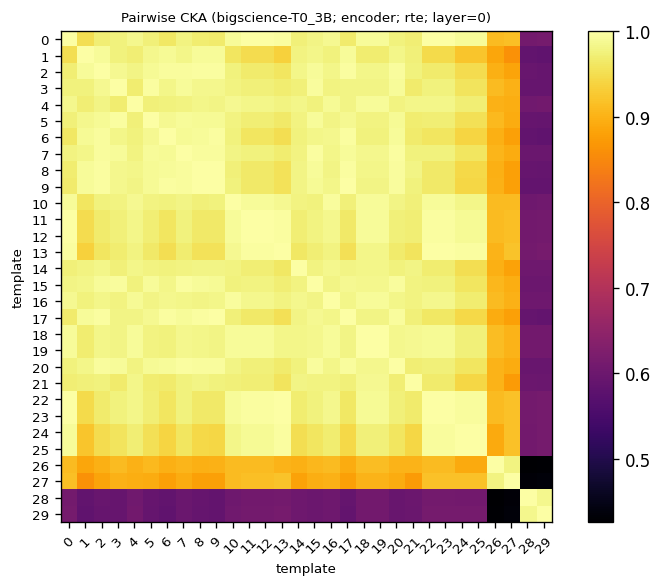

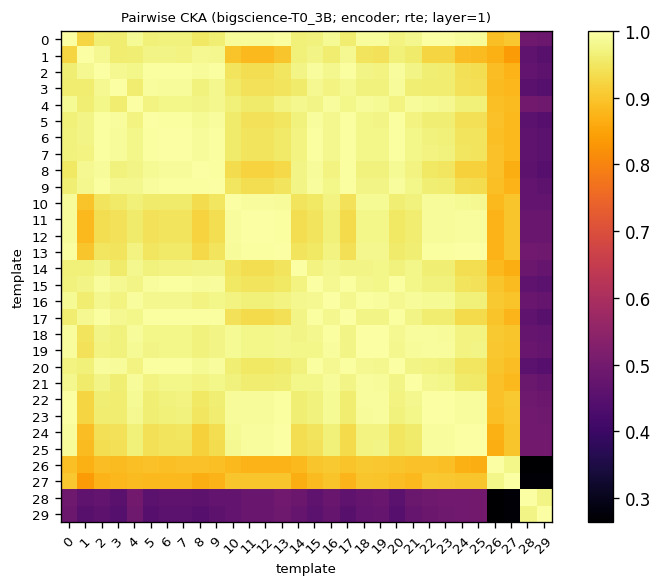

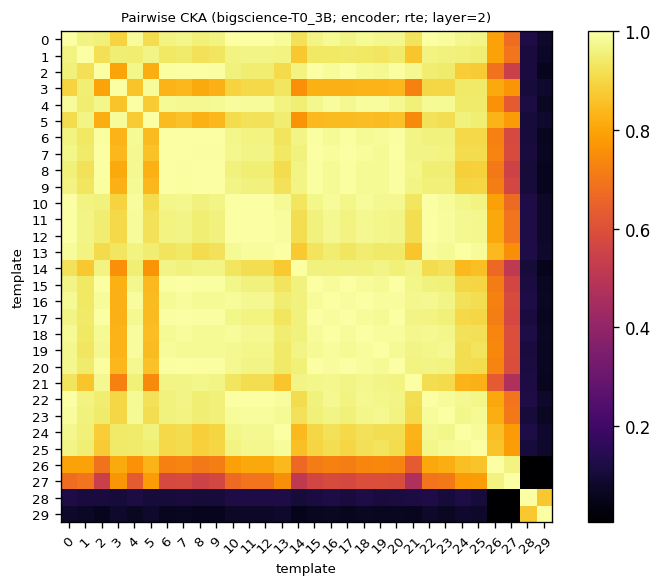

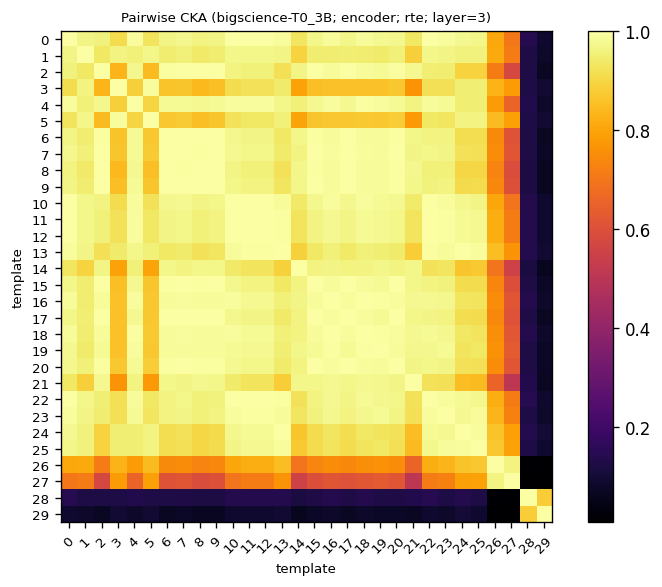

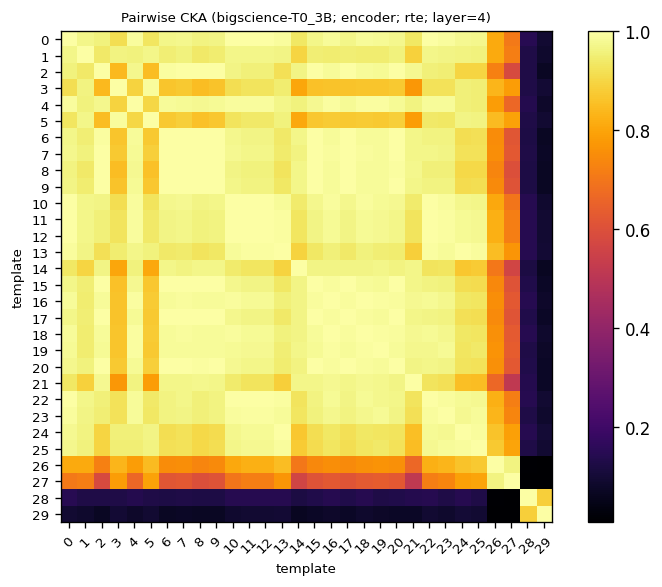

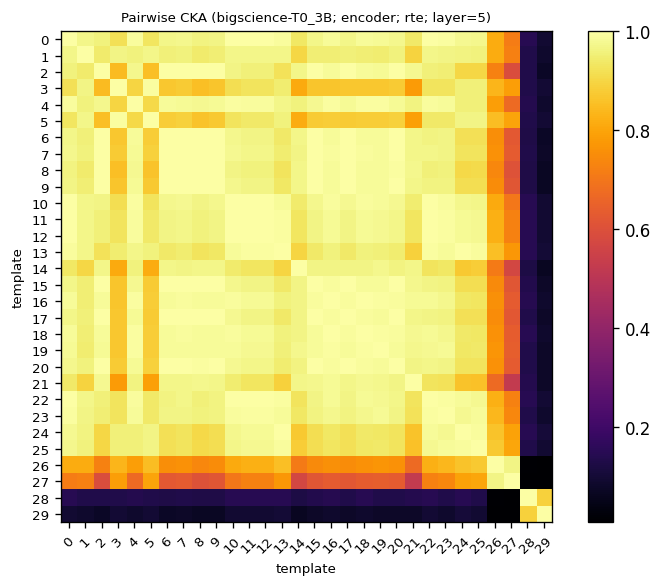

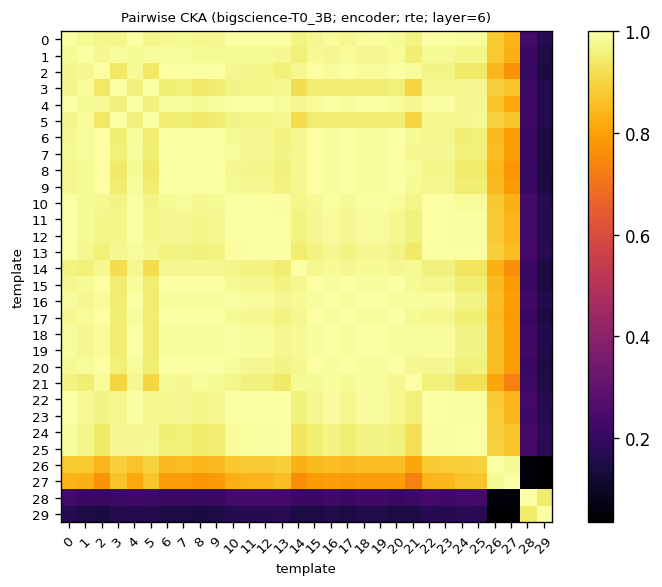

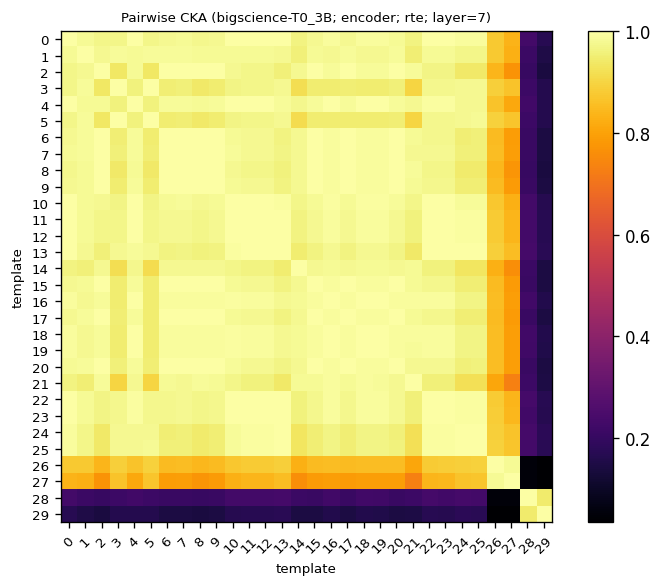

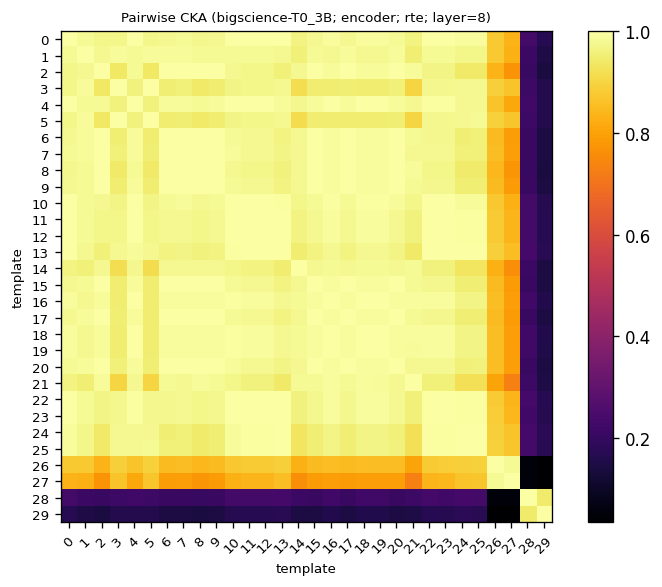

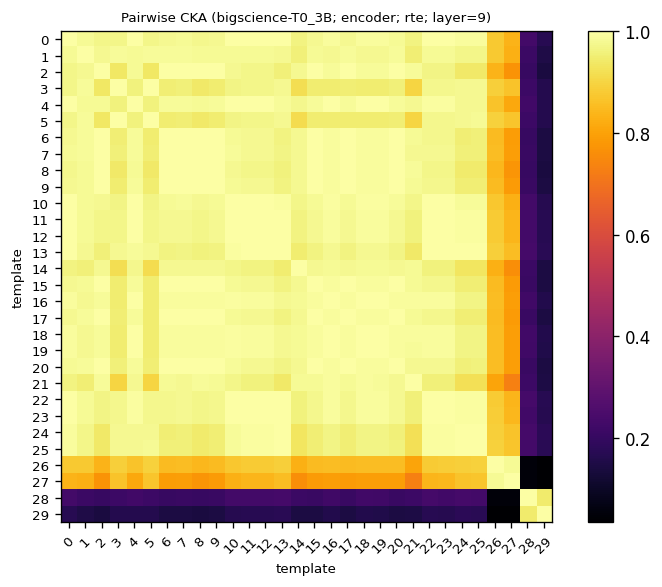

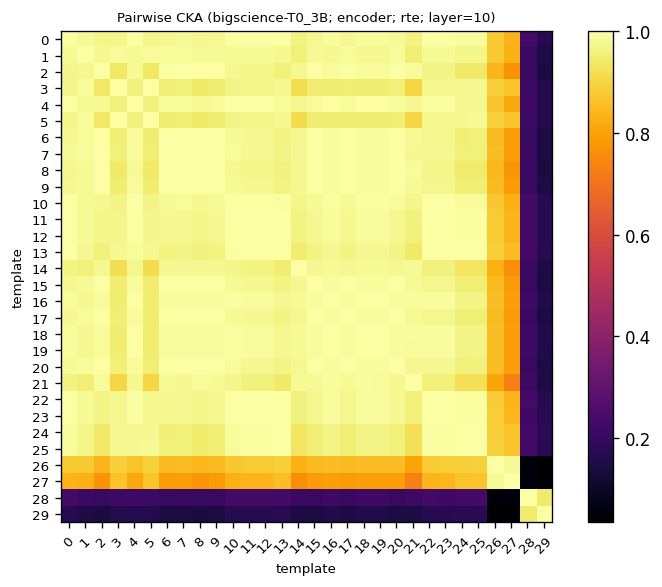

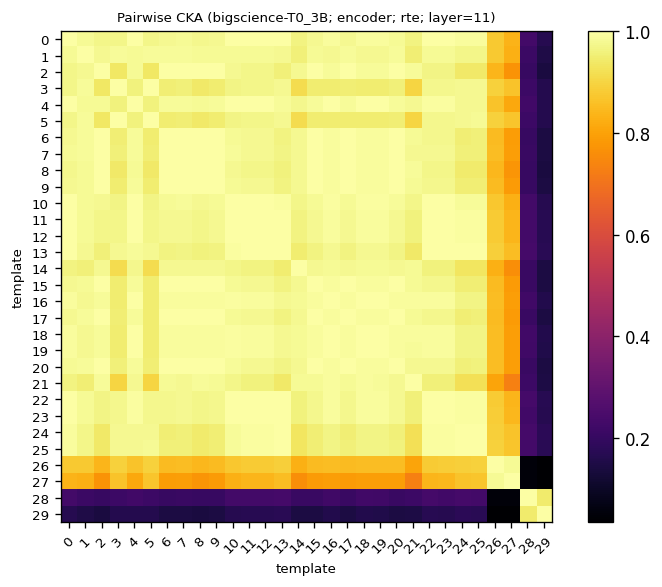

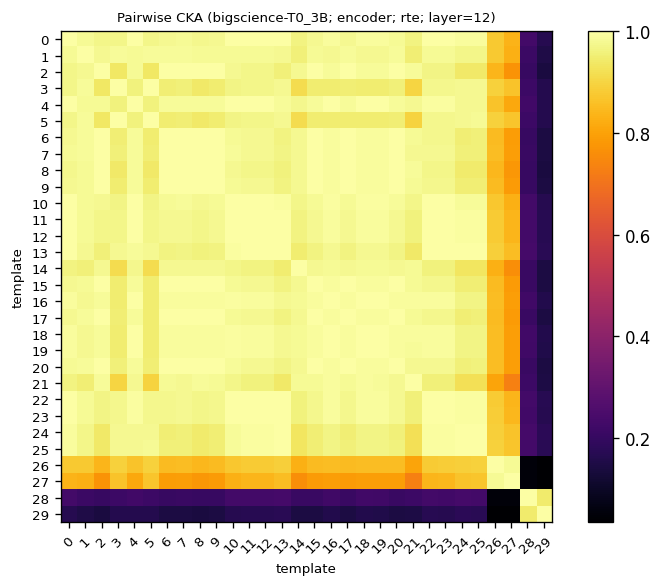

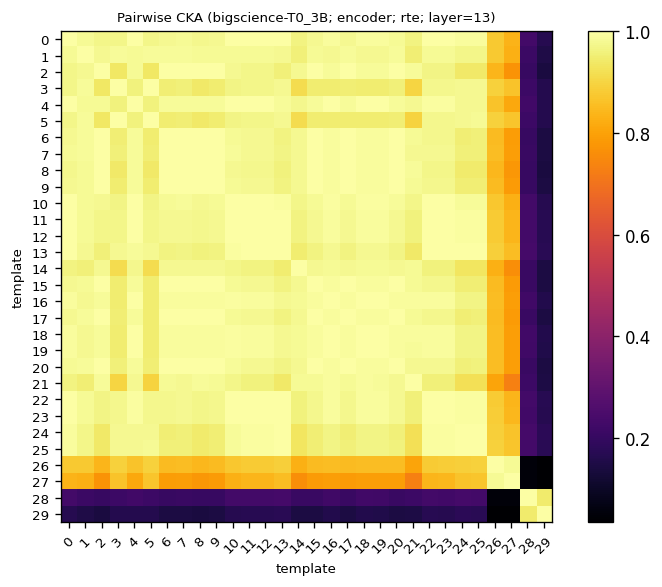

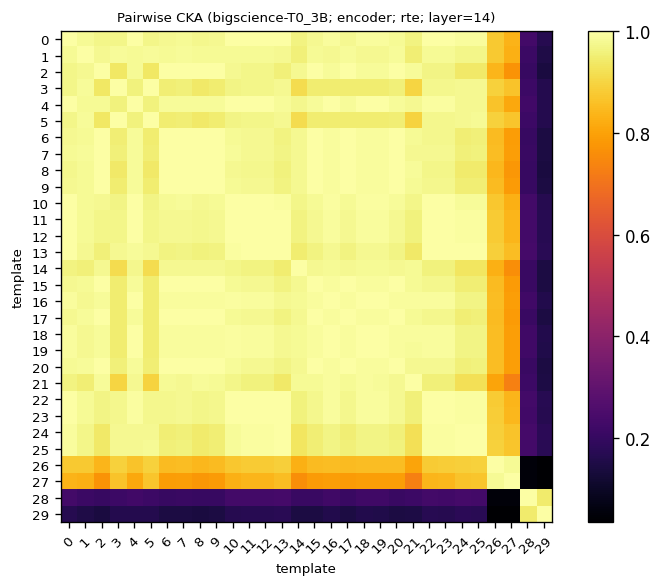

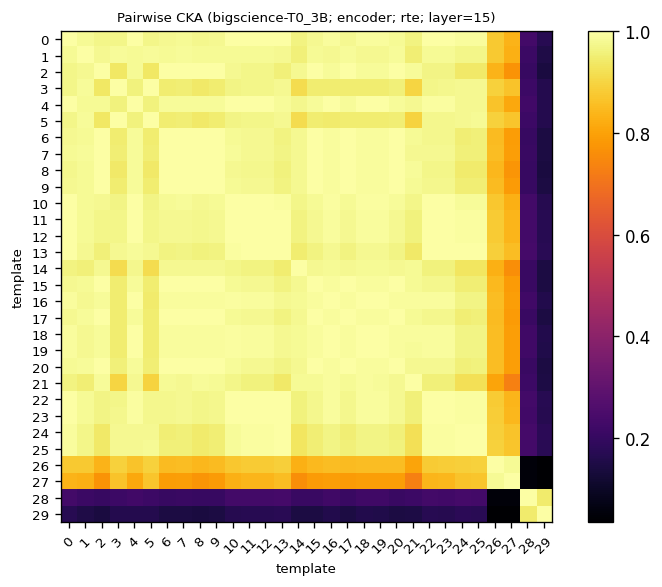

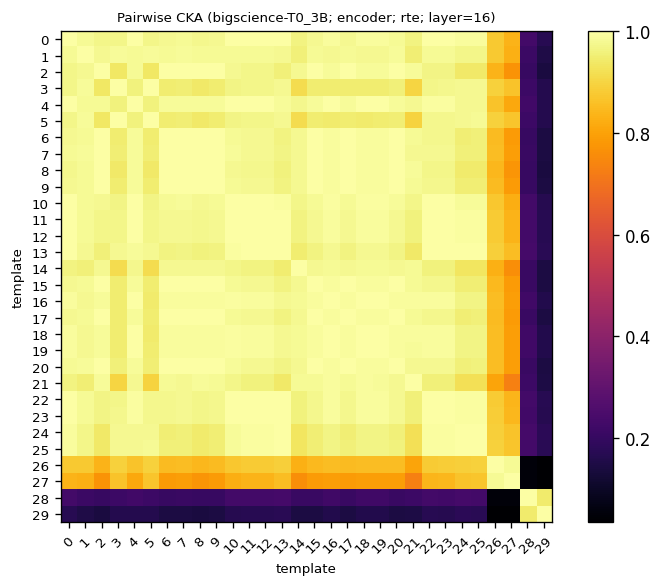

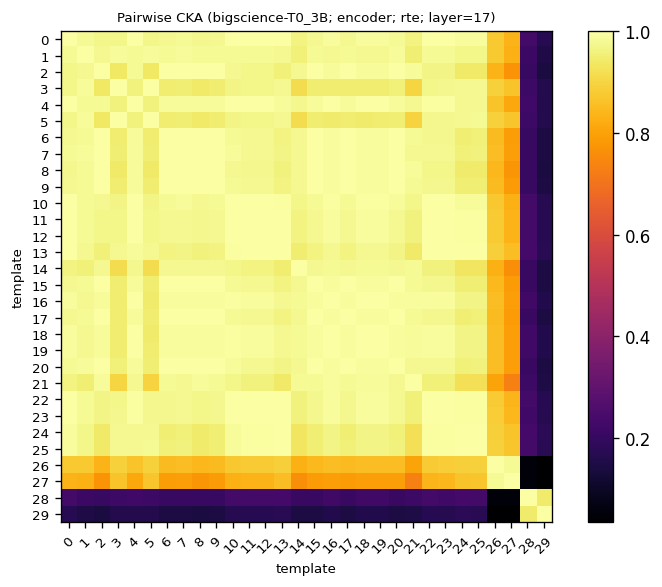

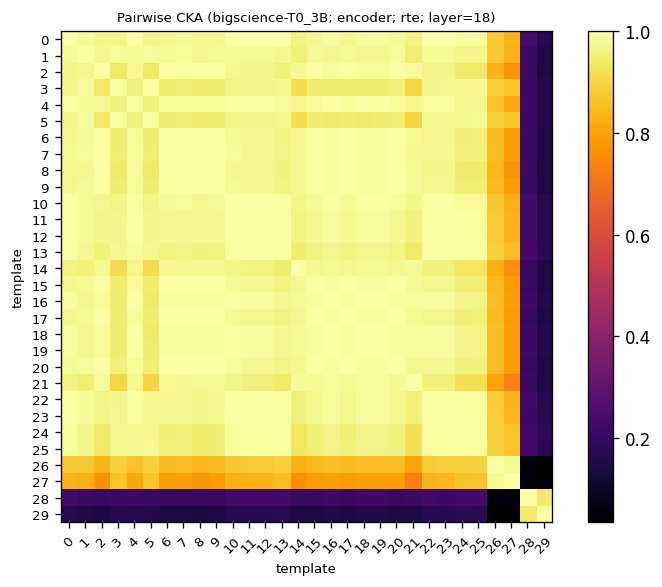

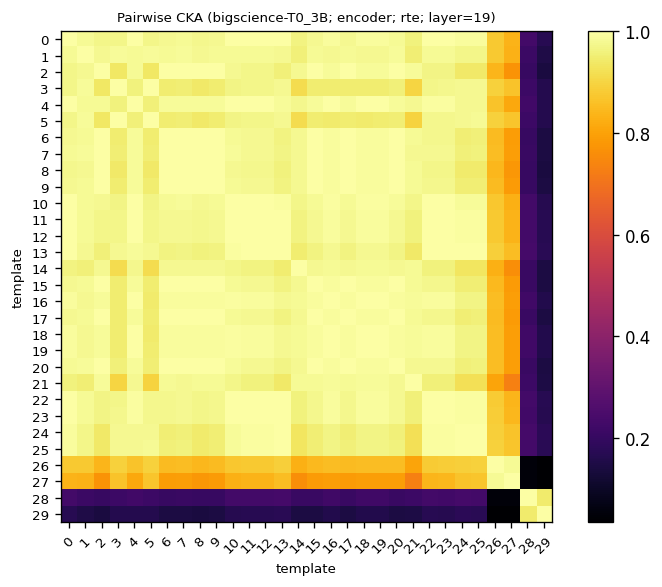

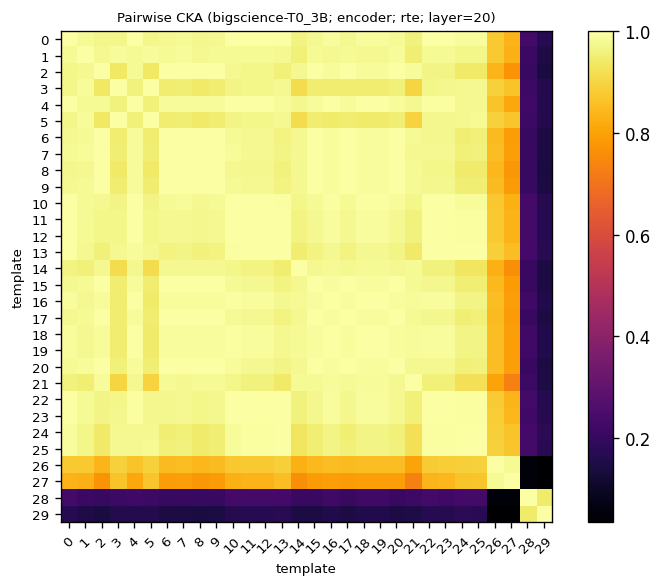

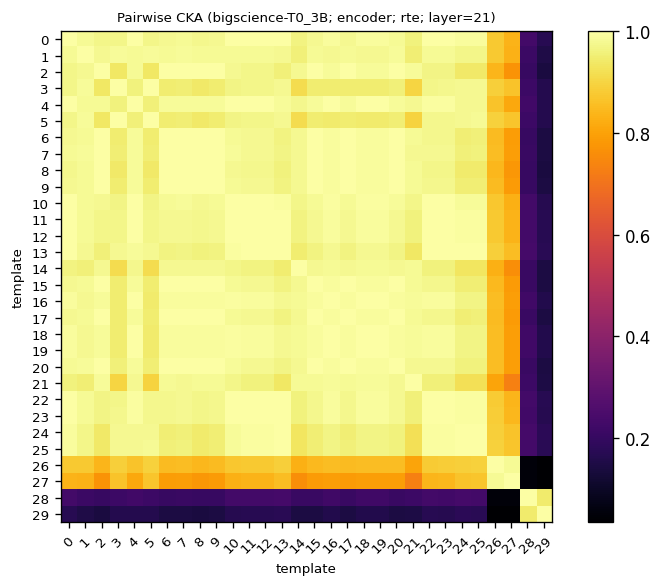

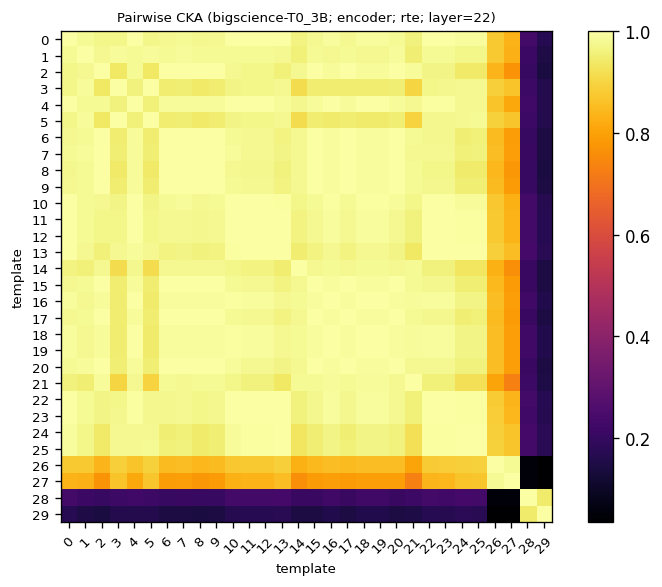

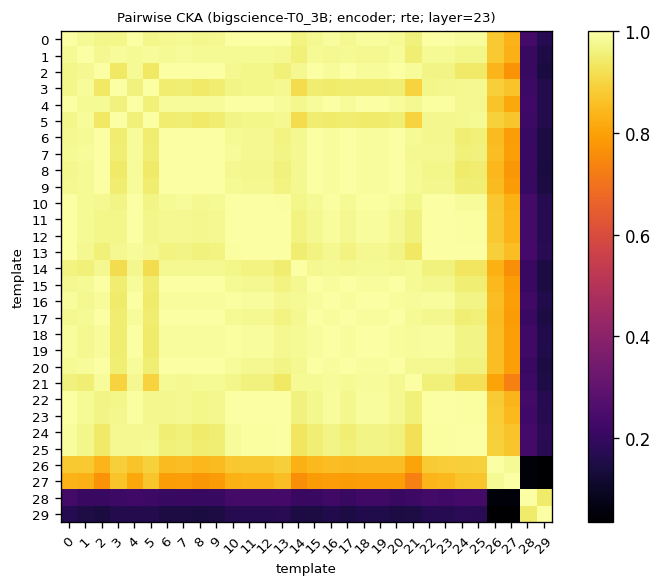

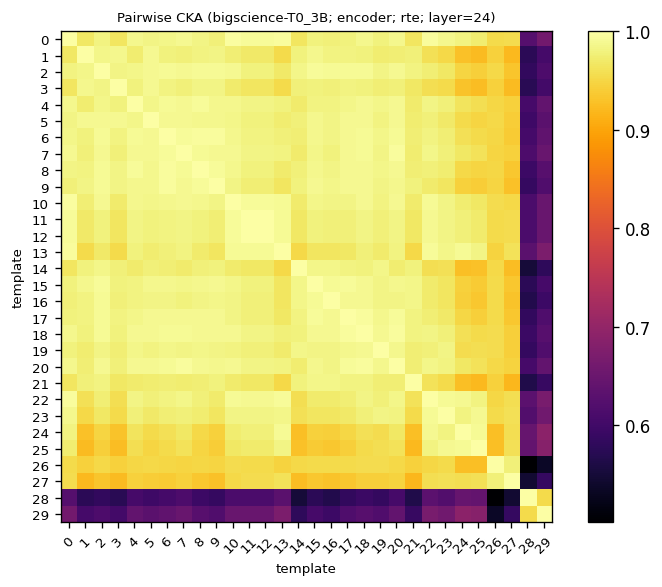

In [11]:
for layer_key in cka_scores_layers.keys():
    values = cka_scores_layers[layer_key]
    layer = layer_key.split('-')[-1]

    fig, axes = plt.subplots(1, 1, figsize=(6.5, 5), dpi=120)

    im = axes.imshow(values, cmap='inferno', vmax=1.0)
    # Create colorbar
    cbar = axes.figure.colorbar(im, ax=axes)
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    axes.set_xlabel("template", fontsize=8)
    axes.set_xticks(np.arange(len(values)))
    axes.set_ylabel("template", fontsize=8)
    axes.set_yticks(np.arange(len(values)))
    plt.xticks(fontsize=8, rotation=45)
    plt.yticks(fontsize=8, rotation=0)

    axes.set_title(f"Pairwise CKA ({model}; {module}; {task}; layer={layer})", fontsize=8)

    plt.tight_layout()
    plt.show()
    plt.close();


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


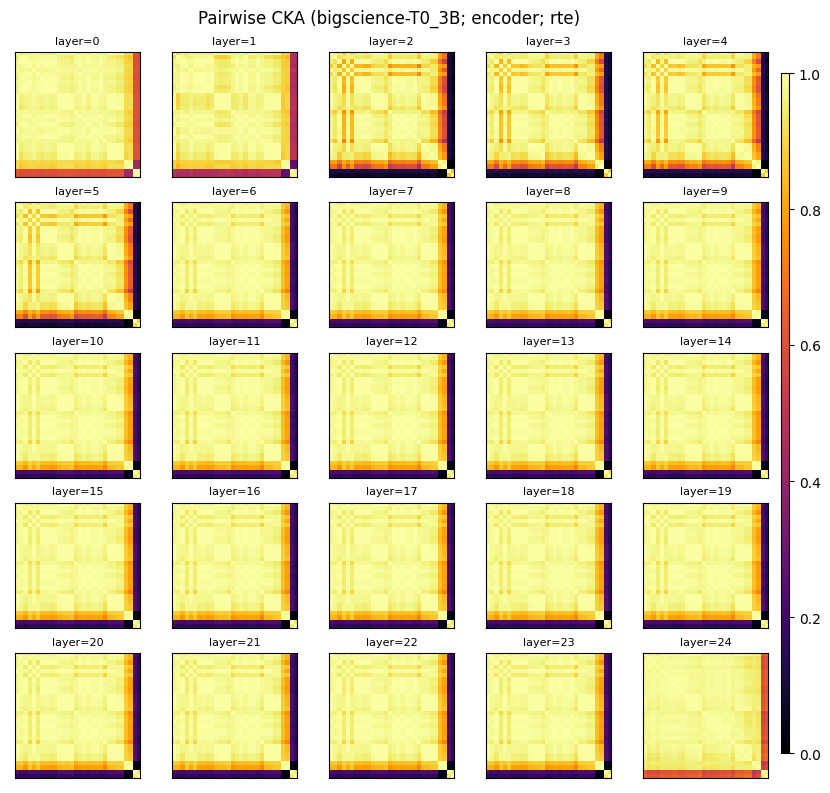

In [14]:
plt.figure(figsize=(8, 8), dpi=100)

for l, layer_key in enumerate(cka_scores_layers.keys()):
    values = cka_scores_layers[layer_key]
    layer = layer_key.split('-')[-1]

    plt.subplot(5, 5, l+1)
    axes = plt.gca()
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    im = axes.imshow(values, cmap='inferno', vmin=0.0, vmax=1.0)
    # Create colorbar
    # cbar = axes.figure.colorbar(im, ax=axes)
    # cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    axes.set_xlabel("template", fontsize=8)
    axes.set_xticks(np.arange(len(values)))
    axes.set_ylabel("template", fontsize=8)
    axes.set_yticks(np.arange(len(values)))

    # axes.set_title(f"Pairwise CKA ({model}; {module}; {task}; layer={layer})", fontsize=8)
    axes.set_title(f"layer={layer}", fontsize=8)

# add colorbar
fig = plt.gcf()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.05, 0.01, 0.85])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle(f"Pairwise CKA ({model}; {module}; {task})")
plt.tight_layout()
plt.show()
plt.close();

In [15]:
df

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
1,mnli_crowdsource_with_targets,"{premise} Using only the above description and what you know about the world, is ""{hypothesis}"" definitely correct? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
2,based_on_previous_passage_with_targets,"{premise} Based on the previous passage, is it true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
3,infer_with_targets,"Suppose {premise} Can we infer that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
4,follow_with_targets,Given that {premise} Does it follow that {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
5,imply_with_targets,"{premise} Question: Does this imply that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
6,guaranteed_with_targets,"Given {premise} Is it guaranteed true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
7,justified_with_targets,"{premise} Are we justified in saying that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
8,must_be_true_with_targets,"Given that {premise} Therefore, it must be true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
9,should_assume_with_targets,"Given {premise} Should we assume that ""{hypothesis}"" is true? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False


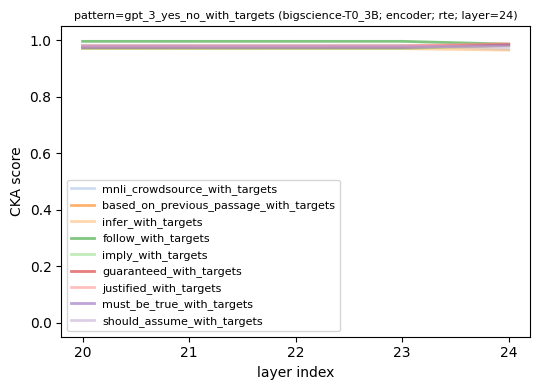

In [16]:
pattern1 = 0

fig, axes = plt.subplots(1, 1, figsize=(5.5, 4), dpi=100)

# cmap = matplotlib.cm.get_cmap('tab10')
cmap = matplotlib.cm.get_cmap('tab20')
colors = cmap.colors

for idx, pattern2 in enumerate(range(len(df))[:10]):
    if pattern2 == pattern1:
        continue
    pattern_sim = []

    layers = []
    for layer in list(cka_scores_layers.keys())[-5:]:
        layers.append(layer.split('-')[-1])
        cka_score = cka_scores_layers[layer][pattern1, pattern2]
        pattern_sim.append(cka_score)
    
    axes.plot(pattern_sim, linewidth=2.0, alpha=0.6, color=colors[idx], label=f"{df.iloc[pattern2]['name']}")

axes.set_ylim(-0.05, 1.05)
axes.set_xticks(np.arange(len(pattern_sim)))
axes.set_xticklabels(layers)
axes.set_xlabel("layer index")
axes.set_ylabel("CKA score")

axes.set_title(f"pattern={df.iloc[pattern1]['name']} ({model}; {module}; {task}; layer={layer.split('-')[-1]})", fontsize=8)

axes.legend(loc='best', fontsize=8)
# Put a legend to the right of the current axis
# axes.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=False, fontsize=8)

plt.tight_layout();